In [2]:
import os
import h5py
import matplotlib.pyplot as plt

import numpy as np

# get current working directory and change it to the directory of this file
cwd = os.getcwd()
print(cwd)


/Users/yaowenshen/Desktop/Master/ConGeLe


In [3]:
fname = "data/data/AOMIC/ds002785/sub-0001/anat/sub-0001_T1w_preprocessed.h5"
f = h5py.File(fname, 'r')
list(f.keys())

['preprocessed_volume']

(160, 192, 160)
float64


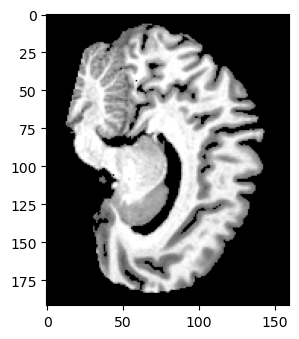

In [25]:
print(f['preprocessed_volume'].shape)  #160,192,160 => x,y,z
print(f['preprocessed_volume'].dtype)
plt.imshow(f['preprocessed_volume'][90, :, :], cmap='gray')

In [13]:
print(f['preprocessed_volume'])
# print(np.array(f['preprocessed_volume']))
print(np.array(f['preprocessed_volume']).shape)

<HDF5 dataset "preprocessed_volume": shape (160, 192, 160), type "<f8">
[[[-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
  [-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
  [-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
  ...
  [-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
  [-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
  [-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]]

 [[-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
  [-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
  [-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
  ...
  [-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
  [-0.49228448 -0.49228448 -0.49228448 ... -0.49228448 -0.49228448
   -0.49228448]
 

In [6]:
from dp_model.model_files.sfcn import SFCN
from dp_model import dp_loss as dpl
from dp_model import dp_utils as dpu
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [21]:
from sfcn_helper import get_bin_range

# Example
model = SFCN()
model = torch.nn.DataParallel(model)
fp_ = './brain_age/run_20190719_00_epoch_best_mae.p'
model.load_state_dict(torch.load(fp_, map_location='cpu'))

# Example data: some random brain in the MNI152 1mm std space
# data = np.random.rand(182, 218, 182)
data = np.array(f['preprocessed_volume'])
label = np.array([26.25, ])  # Assuming the random subject is 71.3-year-old.
# Transforming the age to soft label (probability distribution)
print(f'Label: {label[0]}')
bin_range, bin_step = get_bin_range(label[0])
bin_step = 1
sigma = 1
y, bc = dpu.num2vect(label, bin_range, bin_step, sigma)
y = torch.tensor(y, dtype=torch.float32)
print(f'Label shape: {y.shape}')

# Preprocessing
data = data / data.mean()
# data = dpu.crop_center(data, (160, 192, 160))
print(f'Input data shape: {data.shape}')
# Move the data from numpy to torch tensor on GPU
sp = (1, 1) + data.shape
data = data.reshape(sp)
input_data = torch.tensor(data, dtype=torch.float32)
print(f'Input data shape: {input_data.shape}')
print(f'dtype: {input_data.dtype}')

# Evaluation
model.eval()  # Don't forget this. BatchNorm will be affected if not in eval mode.
with torch.no_grad():
    output = model.module(input_data)

# Output, loss, visualisation
x = output[0].reshape([1, -1])
print(f'Output shape: {x.shape}')
loss = dpl.my_KLDivLoss(x, y).numpy()

# Prediction, Visualisation and Summary
x = x.numpy().reshape(-1)
y = y.numpy().reshape(-1)

plt.bar(bc, y)
plt.title('Soft label')
plt.show()

prob = np.exp(x)
pred = prob @ bc
plt.bar(bc, prob)
plt.title(f'Prediction: age={pred:.2f}\nloss={loss}')
plt.show()

Label: 26.25
Label shape: torch.Size([1, 80])
Input data shape: (160, 192, 160)
Input data shape: torch.Size([1, 1, 160, 192, 160])
dtype: torch.float32
Output shape: torch.Size([1, 40])


RuntimeError: The size of tensor a (80) must match the size of tensor b (40) at non-singleton dimension 1